In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/Data-Analysis-Projects/Credit_Card_Fraud_Detection')
print(os.getcwd())

/content/drive/My Drive/Colab Notebooks/Data-Analysis-Projects/Credit_Card_Fraud_Detection


In [0]:
!pip install catboost

     |████████████████████████████████| 64.4MB 56kB/s 


## Importing Libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
classification_report, confusion_matrix, precision_recall_curve, \
average_precision_score, roc_curve, auc
from sklearn.model_selection import KFold, StratifiedKFold
from catboost import CatBoostClassifier
import time

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Custom Functions
import curves as C

In [0]:
dataset = pd.read_csv('creditcard.csv')
dataset_X = dataset.drop(['Class'], axis = 1)
dataset_y = dataset['Class']

## Splitting the dataset into the Training set and Test set

In [0]:
def split_data(X, y):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False)
    print('train-set size: ', len(y_train), 
          '\ntest-set size: ', len(y_test))    
    print('fraud cases in train-set', sum(y_train),
          '\nfraud cases in test-set: ', sum(y_test))
    return X_train, X_test, y_train, y_test

## Define function to get predictions

In [0]:
def get_predictions(y_true, y_pred): 
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    sns.heatmap(cm, cmap = "coolwarm", annot = True, linewidths = 0.5)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted class")
    plt.ylabel("Real class")
    plt.show()
    
    print('==============================')
    print(cm)
    print('==============================')
    print('accuracy = {}'.format(accuracy))
    print('precision = {}'.format(precision))
    print('recall = {}'.format(recall))
    print('f1 score = {}'.format(f1))
    print('==============================')
    print(classification_report(y_true, y_pred))

## Feature importance plot

In [0]:
def plot_feature_importance(model, predictors):
    tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': model.feature_importances_})
    tmp = tmp.sort_values(by = 'Feature importance', ascending = False)
    plt.figure(figsize = (15, 8))
    plt.title('Features importance', fontsize = 14)
    s = sns.barplot(x = 'Feature', y = 'Feature importance', data = tmp)
    s.set_xticklabels(s.get_xticklabels(), rotation = 45)
    plt.show()

## Case 1: Drop 'Time', 'Amount'

In [0]:
drop_list = ['Time', 'Amount']
# drop_list = ['Time', 'Amount', 'V28', 'V27', 'V26', 'V25', 'V24', 'V23', 'V22', 'V20', 'V15', 'V13', 'V8']
X = dataset_X.drop(drop_list, axis = 1)
predictor_name = X.columns
X = X.values
y = dataset_y.values
print(predictor_name)
X_train, X_test, y_train, y_test = split_data(X, y)

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28'],
      dtype='object')
train-set size:  199364 
test-set size:  85443
fraud cases in train-set 384 
fraud cases in test-set:  108


 ## 1. CatBoostClassifier

### 1.1 CatBoostClassifier - Without hyperparameters tuning
EX: CatBoostClassifier(loss_function = 'Logloss', eval_metric = 'AUC', learning_rate = 0.1)

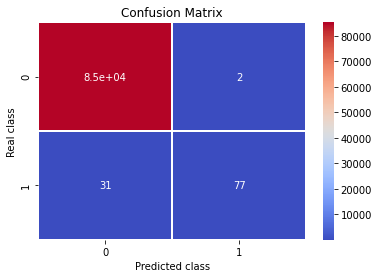

[[85333     2]
 [   31    77]]
accuracy = 0.9996137776061234
precision = 0.9746835443037974
recall = 0.7129629629629629
f1 score = 0.8235294117647057
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85335
           1       0.97      0.71      0.82       108

    accuracy                           1.00     85443
   macro avg       0.99      0.86      0.91     85443
weighted avg       1.00      1.00      1.00     85443



In [0]:
# cb_clf = CatBoostClassifier(iterations = 200, learning_rate = 0.5, verbose = 0)
cb_clf = CatBoostClassifier(loss_function = 'Logloss', 
                            eval_metric = 'F1', 
                            learning_rate = 0.1, 
                            iterations = 100, 
                            verbose = 0, 
                            task_type = 'GPU')
cb_clf.fit(X_train, y_train)
y_score = cb_clf.predict_proba(X_test)[:, 1]
y_pred = cb_clf.predict(X_test)
get_predictions(y_true = y_test, y_pred = y_pred)

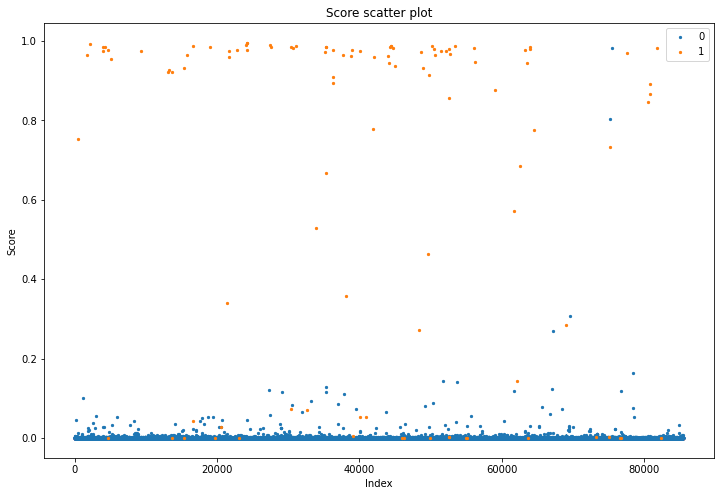

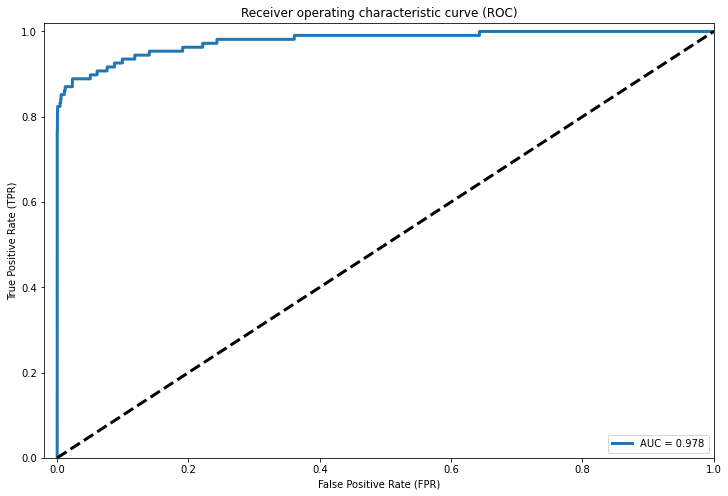

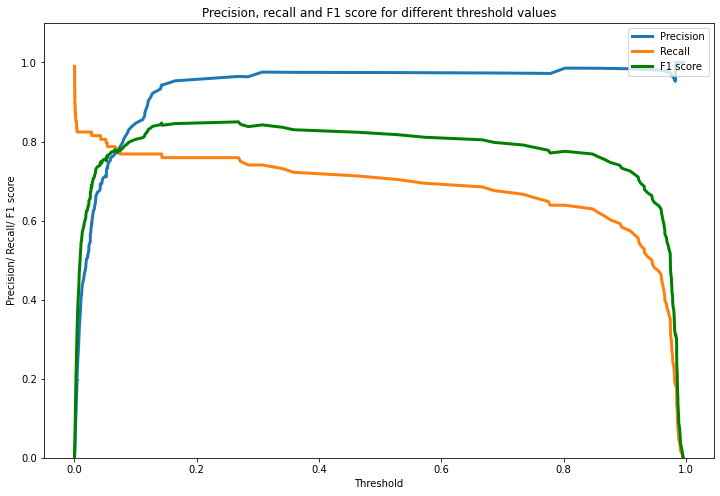

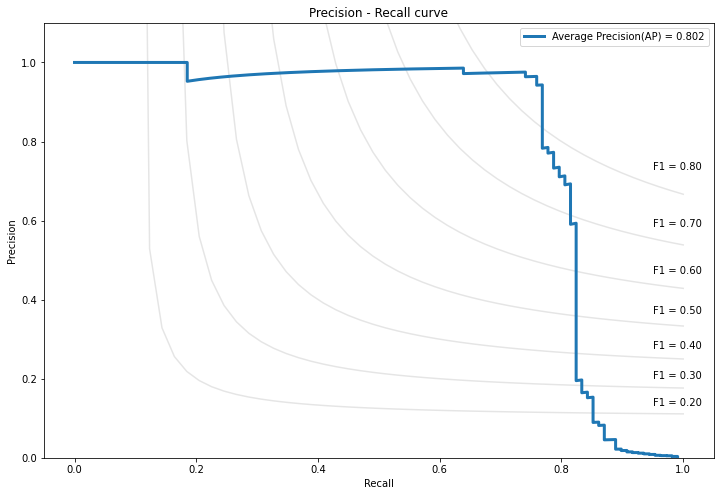

In [0]:
# Plot scores, ROC, Precision, Recall, F1 curve, Precision-Recall curve
C.plot_scores(y_true = y_test, y_score = y_score)
fpr_cb, tpr_cb, roc_auc_cb = C.plot_ROC(y_true = y_test, y_score = y_score)
precision_cb, recall_cb, threshold_cb, f1_scores_cb = C.plot_precision_recall_vs_threshold(y_true = y_test, y_score = y_score)
_, _, pr_auc_cb = C.plot_precision_recall(y_true = y_test, y_score = y_score)

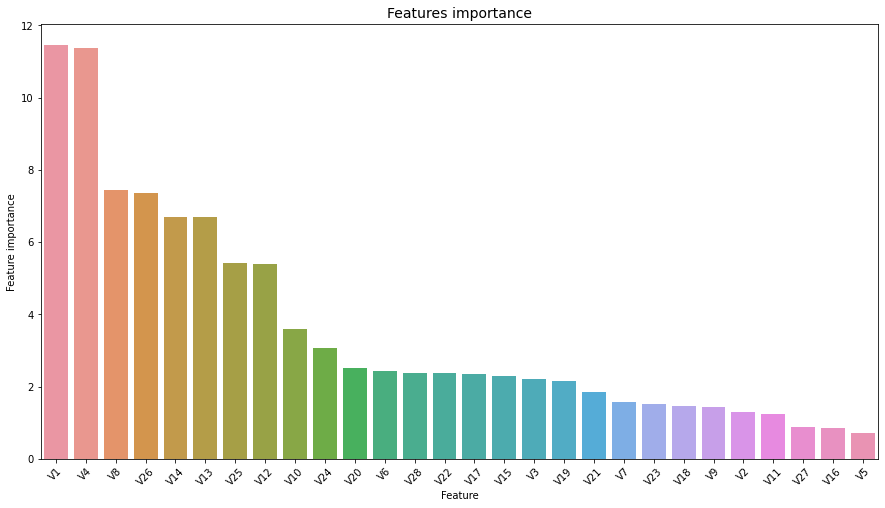

In [0]:
# Plot Feature importance
plot_feature_importance(model = cb_clf, predictors = predictor_name)

### 1.2 Randomized Search CV to optimize 'F1'

In [0]:
from scipy.stats import randint
from scipy.stats import uniform
classifier = CatBoostClassifier(loss_function = 'Logloss', 
                                eval_metric = 'F1', 
                                task_type = 'GPU')

parameter = {'learning_rate': uniform(loc = 0, scale = 0.1), 
             'iterations': [50, 100, 200], 
             'depth': randint(low = 1, high = 11), 
             'l2_leaf_reg': uniform(loc = 0, scale = 10)}

skf = StratifiedKFold(n_splits = 5, random_state = 0)
tStart = time.time()
randomized_search_result = classifier.randomized_search(param_distributions = parameter, 
                                                        X = X_train,
                                                        y = y_train, 
                                                        cv = skf, 
                                                        n_iter = 100, 
                                                        plot = True)
tEnd = time.time()
rand_best_parameters = randomized_search_result['params']
print('It costs {:.2f} sec.'.format(tEnd - tStart))
print(rand_best_parameters)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 0.0000000	best: 0.0000000 (0)	total: 4.77s	remaining: 7m 52s
1:	loss: 0.6666667	best: 0.6666667 (1)	total: 6.72s	remaining: 5m 29s
2:	loss: 0.7600000	best: 0.7600000 (2)	total: 23.4s	remaining: 12m 37s
3:	loss: 0.7692308	best: 0.7692308 (3)	total: 34.4s	remaining: 13m 44s
4:	loss: 0.4102564	best: 0.7692308 (3)	total: 36.5s	remaining: 11m 33s
5:	loss: 0.3243243	best: 0.7692308 (3)	total: 38.6s	remaining: 10m 4s
6:	loss: 0.7083333	best: 0.7692308 (3)	total: 45.3s	remaining: 10m 1s
7:	loss: 0.7346939	best: 0.7692308 (3)	total: 48.6s	remaining: 9m 18s
8:	loss: 0.7083333	best: 0.7692308 (3)	total: 51s	remaining: 8m 35s
9:	loss: 0.7600000	best: 0.7692308 (3)	total: 54.3s	remaining: 8m 8s
10:	loss: 0.7600000	best: 0.7692308 (3)	total: 56.5s	remaining: 7m 37s
11:	loss: 0.7600000	best: 0.7692308 (3)	total: 58.7s	remaining: 7m 10s
12:	loss: 0.7777778	best: 0.7777778 (12)	total: 1m 17s	remaining: 8m 41s
13:	loss: 0.7450980	best: 0.7777778 (12)	total: 1m 20s	remaining: 8m 12s
14:	loss: 0.

### 1.3 CatBoost with best parameters

0:	learn: 0.8153409	total: 13.1ms	remaining: 642ms
1:	learn: 0.8484006	total: 24.9ms	remaining: 597ms
2:	learn: 0.8555556	total: 37.1ms	remaining: 581ms
3:	learn: 0.8559441	total: 48.8ms	remaining: 561ms
4:	learn: 0.8519041	total: 60.9ms	remaining: 548ms
5:	learn: 0.8575419	total: 73ms	remaining: 535ms
6:	learn: 0.8619718	total: 85.5ms	remaining: 525ms
7:	learn: 0.8647887	total: 97.4ms	remaining: 511ms
8:	learn: 0.8635724	total: 109ms	remaining: 498ms
9:	learn: 0.8635724	total: 121ms	remaining: 484ms
10:	learn: 0.8631876	total: 133ms	remaining: 473ms
11:	learn: 0.8644068	total: 145ms	remaining: 461ms
12:	learn: 0.8644068	total: 157ms	remaining: 447ms
13:	learn: 0.8660085	total: 173ms	remaining: 446ms
14:	learn: 0.8672316	total: 185ms	remaining: 432ms
15:	learn: 0.8672316	total: 197ms	remaining: 418ms
16:	learn: 0.8704225	total: 214ms	remaining: 415ms
17:	learn: 0.8688293	total: 228ms	remaining: 406ms
18:	learn: 0.8688293	total: 240ms	remaining: 392ms
19:	learn: 0.8720113	total: 251ms	r

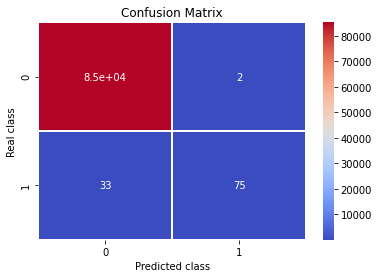

[[85333     2]
 [   33    75]]
accuracy = 0.9995903701883126
precision = 0.974025974025974
recall = 0.6944444444444444
f1 score = 0.8108108108108107
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85335
           1       0.97      0.69      0.81       108

    accuracy                           1.00     85443
   macro avg       0.99      0.85      0.91     85443
weighted avg       1.00      1.00      1.00     85443



In [0]:
cb_clf = CatBoostClassifier(loss_function = 'Logloss', 
                            eval_metric = 'F1',
                            task_type = 'GPU',
                            ** rand_best_parameters)
cb_clf.fit(X_train, y_train)
y_score = cb_clf.predict_proba(X_test)[:, 1]
y_pred = cb_clf.predict(X_test)
get_predictions(y_true = y_test, y_pred = y_pred)

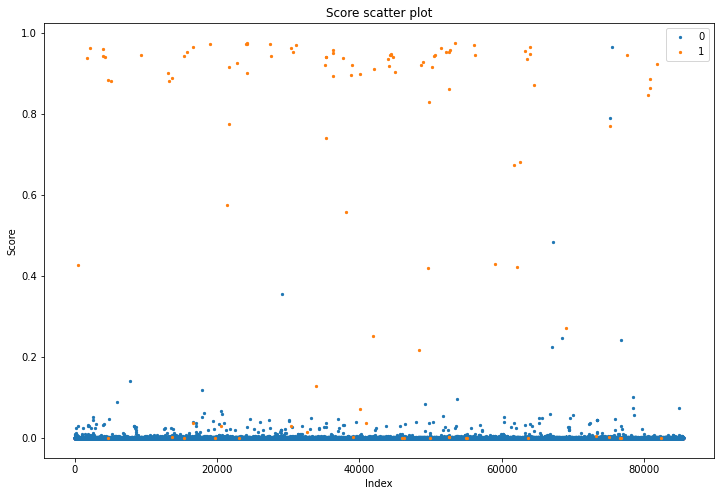

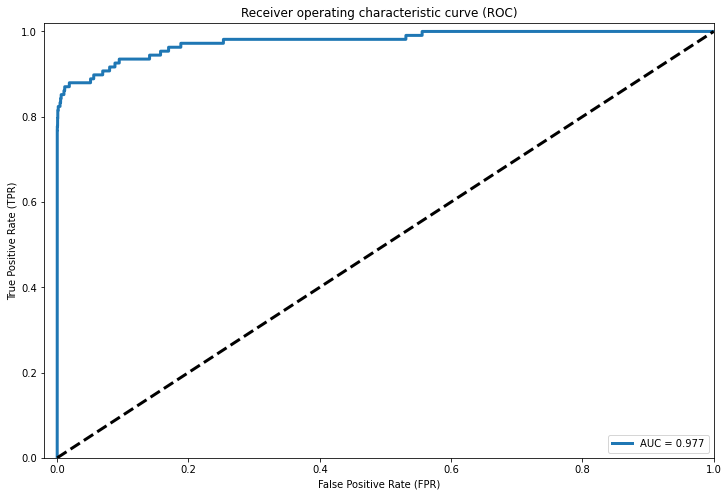

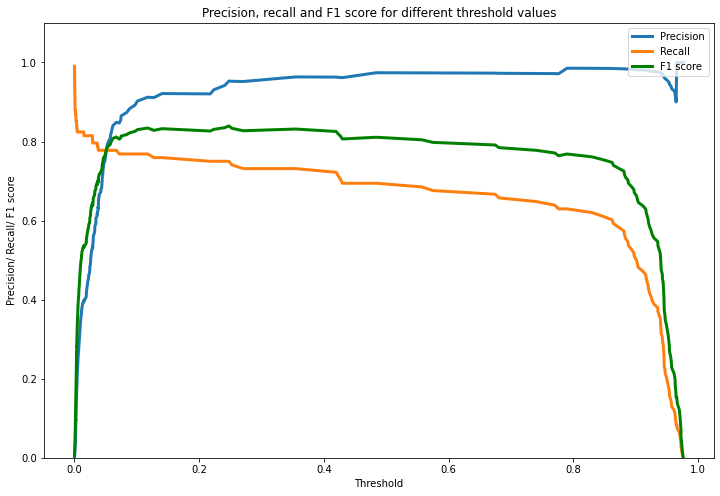

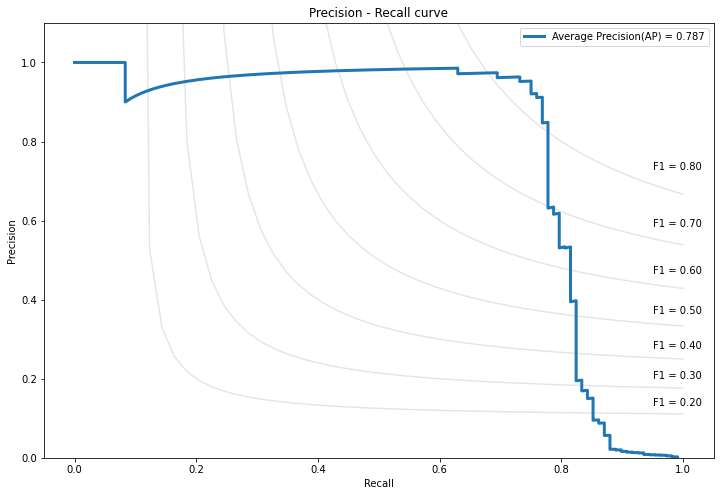

In [0]:
# Plot scores, ROC, Precision, Recall, F1 curve, Precision-Recall curve
C.plot_scores(y_true = y_test, y_score = y_score)
fpr_cb, tpr_cb, roc_auc_cb = C.plot_ROC(y_true = y_test, y_score = y_score)
precision_cb, recall_cb, threshold_cb, f1_scores_cb = C.plot_precision_recall_vs_threshold(y_true = y_test, y_score = y_score)
_, _, pr_auc_cb = C.plot_precision_recall(y_true = y_test, y_score = y_score)

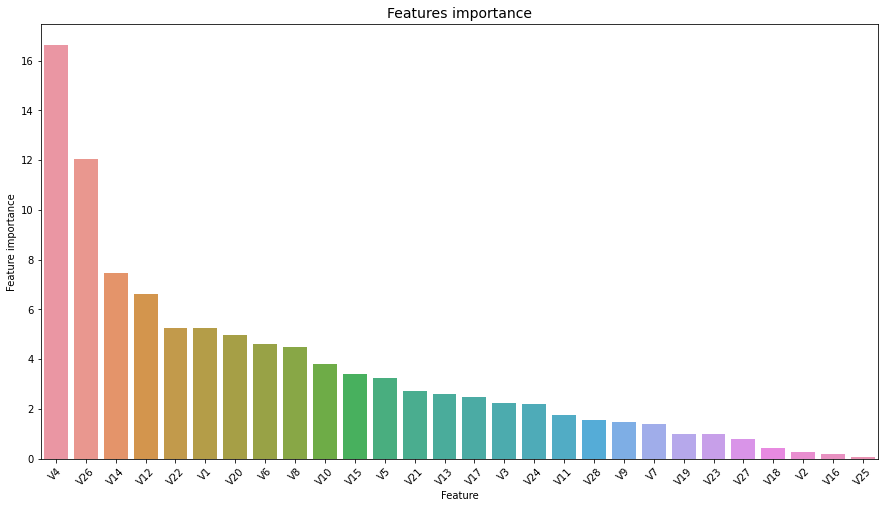

In [0]:
# Plot Feature importance
plot_feature_importance(model = cb_clf, predictors = predictor_name)